# Heterojunction offsets

Heterojunctions are the basis of much of the semiconductor technology. From computer memory, to flat-panel display to photovoltaics, semiconductor heterojuctions underly much of the technology created in the past 100 years. Previosuly we constructed band-alignment-diagrams using the IP and EA from slab calculations. However, the details of the interface can also affect the line-up, from charge transfer and lattice strain effects, for example. For an excellent overview of the subject, I recommend: [Band engineering at interfaces: theory and numerical experiments](http://iopscience.iop.org/article/10.1088/0022-3727/31/11/002/meta).

## Our system 

For this demonstration we will choose a well-matched interface system. The interface between wurtzite structured ZnO and ZnS. In this case the lattice constants have been set to be those of ZnO. Obviously, due to deformation potentials the value of the offset depends on the lattice parameter used.

<img src="HJ.png">

## Procedure

We present two procedures for obtaining the offset from a heterojunction calulcation. 

(i) We will intitally calculate the offset for the interface as we have modelled it, this essentially involves the calculation of the macroscopic average of the potential.


(ii) We will then look at how the effects of strain at the interface can be accounted for to yield a "natural band offset". As outlined in [Appl. Phys. Lett. 94, 212109 (2009)](http://aip.scitation.org/doi/10.1063/1.3143626).

### Procedure (i)

$VBO = \epsilon_{vbm}^a - \epsilon_{vbm}^b + \Delta V$

$VBO$ is the offset. $\epsilon_{vbm}$ are the eigenvalues of the highest occupied bands from bulk calculations of the two materials (ZnO and ZnS) and $\Delta V$ is the offset in the potential across the interface.

We obtain the $\epsilon_{vbm}$ values from the bulk `OUTCAR` files as in the slab model exercise. 


In [7]:
%%bash
nkpts=`grep NKPTS OUTCAR.ZnS | awk '{print $4}'`
uband=`grep NELECT OUTCAR.ZnS | awk '{print $3/2}'`
grep "  $uband   " OUTCAR.ZnS | tail -$nkpts | awk '{print $2}' | sort -n | head | tail -1

1.0482


In [8]:
%%bash
nkpts=`grep NKPTS OUTCAR.ZnO | awk '{print $4}'`
uband=`grep NELECT OUTCAR.ZnO | awk '{print $3/2}'`
grep "  $uband   " OUTCAR.ZnO | tail -$nkpts | awk '{print $2}' | sort -n | head | tail -1

-0.7048


### Interface calculation

Now we do a calculation of the interface to get the potential profile. Important settings for the `INCAR` file:

    LVHAR = .TRUE.  # This generates a LOCPOT file with the potential 
    
In your example directory there should already be a `LOCPOT` file. This is the one we will use to analyse the potential and extract the value of $\Delta V$.

In the sample `PlanarAverage.py` file, all we have to edit are the top three lines. Of these the only one that is not obvious is the `lattice_vector` parameter. This is just the periodicity of the slab in the direction normal to the surface. In the picture below, this is just the distance between the layers of ZnO.

<img src="HJ.png">

In [1]:
%matplotlib inline
import macrodensity as md
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
input_file = 'LOCPOT'
lattice_vector = 3.6
output_file = 'planar.dat'

### The code below is usually set in the PlanarAverage.py file; you don't need to edit it

In [4]:
vasp_pot, NGX, NGY, NGZ, Lattice = md.read_vasp_density(input_file)
vector_a,vector_b,vector_c,av,bv,cv = md.matrix_2_abc(Lattice)
resolution_x = vector_a/NGX
resolution_y = vector_b/NGY
resolution_z = vector_c/NGZ
grid_pot, electrons = md.density_2_grid(vasp_pot,NGX,NGY,NGZ)

Reading potential at point 100000
Reading potential at point 200000
Reading potential at point 300000
Reading potential at point 400000
BBBB		OOOO		OOOO		MMMMM	
BBBB		OOOO		OOOO		MMMMM	
BBBB		OOOO		OOOO		MMMMM	
B  B	        OOOO		OOOO		MMMMM	
B  B	        O  O		O  O		MMMMM	
B  B	        O  O		O  O		MMMMM	
B  B	        O  O		O  O		MMMMM	
B  B	        O  O		O  O		MMMMM	
BBBB	        O  O            O  O		M M M	
BBBB	        O  O		O  O		M M M	
BBBB	        O  O		O  O		M M M	
B  B	        O  O		O  O		M M M	
B  B	        O  O		O  O		M M M	
B  B	        O  O		O  O		M M M	
B  B	        O  O		O  O		M M M	
B  B	        OOOO    	OOOO		M M M	
BBBB            OOOO	        OOOO		M M M	
BBBB            OOOO	        OOOO		M M M	
BBBB            OOOO	        OOOO		M M M	
('Average of the potential = ', -2.2758514649554162e-13)


### The code below will prompt you to say which axis you want to average along

In [5]:
## POTENTIAL
planar = md.planar_average(grid_pot,NGX,NGY,NGZ)
## MACROSCOPIC AVERAGE
macro  = md.macroscopic_average(planar,lattice_vector,resolution_z)

Which axis do you wish to plot along?(x,y,z)LOWER CASE!! z
('Average of the average = ', -2.2248869413488137e-13)


### Now we can plot the results

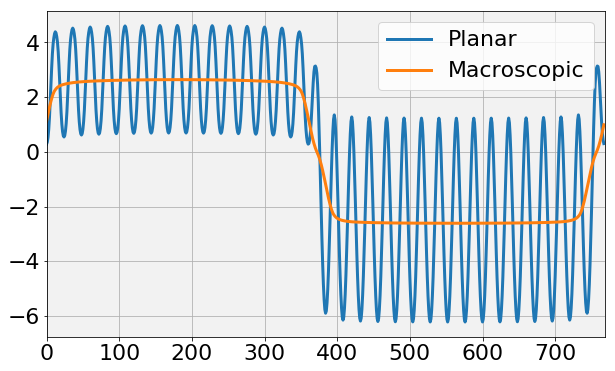

In [7]:
fig, ax1 = plt.subplots(1, 1, sharex=True)

textsize = 22
mpl.rcParams['xtick.labelsize'] = textsize
mpl.rcParams['ytick.labelsize'] = textsize
mpl.rcParams['figure.figsize'] = (10, 6)

ax1.plot(planar,label="Planar",lw=3)
ax1.plot(macro,label="Macroscopic",lw=3)

ax1.set_xlim(0,len(planar))

ax1.set_facecolor((0.95,0.95,0.95))
ax1.grid(True)

ax1.legend(fontsize=22)
plt.show()
np.savetxt(output_file,macro)

### Get $\Delta V$

From inspection of the macroscopic average, saved in `planar.dat` we can find that the value of $V$ at each plateau is 2.64 V and -2.61 V. So the step $\Delta V$ is 5.25 V

### The offset

Applying the equation from earlier, the VBO is 

-0.71 - 1.04 + 5.25 = 3.5 eV

### Procedure (ii)

In this procedure we can take into account the fact that the band edge positions are affected by changes to the cell volume. To do this we first calculate the eigenvalues $\epsilon_{VBM}$ at an *average* volume of the two materials.

In [8]:
%%bash
nkpts=`grep NKPTS OUTCAR_ZnS_av | awk '{print $4}'`
uband=`grep NELECT OUTCAR_ZnS_av | awk '{print $3/2}'`
grep "  $uband   " OUTCAR_ZnS_av | tail -$nkpts | awk '{print $2}' | sort -n | head | tail -1

1.8841


In [9]:
%%bash
nkpts=`grep NKPTS OUTCAR_ZnO_av | awk '{print $4}'`
uband=`grep NELECT OUTCAR_ZnO_av | awk '{print $3/2}'`
grep "  $uband   " OUTCAR_ZnO_av | tail -$nkpts | awk '{print $2}' | sort -n | head | tail -1

-2.0876


### The deformation potential

To account for the effect of strain on the band positions we need to know the deformation potential $\alpha$. In this case the values for $\alpha$ of ZnO and ZnS (and many other systems) are available [Phys. Rev. B 73, 245206](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.73.245206).

$\alpha_{ZnO} = 0.48$

$\alpha_{ZnS} = 0.83$

The equation we now use is 

$ VBO = \epsilon_{vbm}^a - \epsilon_{vbm}^b + \Delta V + \alpha_A \partial \ln V_A - \alpha_B \partial \ln V_B $

Here the eigenvalues and offset potential are the same as in procedure (i), but calculated for an average volume cell. We also use the log of the change in volume of each phase multiplied by the deformation potential ($ \alpha_B \partial \ln V_B $).

### The potential alignment

This procedure is the same as for procedure (i), but always using the average volume cell. Actually as we used the average cell in procedure (i), it turns out to be exactly the same. But we can do it again to reinforce.

Reading potential at point 100000
Reading potential at point 200000
Reading potential at point 300000
Reading potential at point 400000
BBBB		OOOO		OOOO		MMMMM	
BBBB		OOOO		OOOO		MMMMM	
BBBB		OOOO		OOOO		MMMMM	
B  B	        OOOO		OOOO		MMMMM	
B  B	        O  O		O  O		MMMMM	
B  B	        O  O		O  O		MMMMM	
B  B	        O  O		O  O		MMMMM	
B  B	        O  O		O  O		MMMMM	
BBBB	        O  O            O  O		M M M	
BBBB	        O  O		O  O		M M M	
BBBB	        O  O		O  O		M M M	
B  B	        O  O		O  O		M M M	
B  B	        O  O		O  O		M M M	
B  B	        O  O		O  O		M M M	
B  B	        O  O		O  O		M M M	
B  B	        OOOO    	OOOO		M M M	
BBBB            OOOO	        OOOO		M M M	
BBBB            OOOO	        OOOO		M M M	
BBBB            OOOO	        OOOO		M M M	
('Average of the potential = ', 1.2416734307407752e-13)
Which axis do you wish to plot along?(x,y,z)LOWER CASE!! z
('Average of the average = ', 1.2094029481583371e-13)


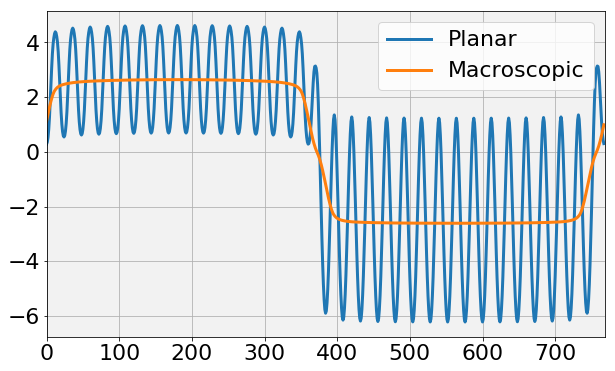

In [10]:
input_file = 'LOCPOT_interface.vasp'
lattice_vector = 3.6
output_file = 'planar.dat'

vasp_pot, NGX, NGY, NGZ, Lattice = md.read_vasp_density(input_file)
vector_a,vector_b,vector_c,av,bv,cv = md.matrix_2_abc(Lattice)
resolution_x = vector_a/NGX
resolution_y = vector_b/NGY
resolution_z = vector_c/NGZ
grid_pot, electrons = md.density_2_grid(vasp_pot,NGX,NGY,NGZ)

## POTENTIAL
planar = md.planar_average(grid_pot,NGX,NGY,NGZ)
## MACROSCOPIC AVERAGE
macro  = md.macroscopic_average(planar,lattice_vector,resolution_z)

fig, ax1 = plt.subplots(1, 1, sharex=True)

textsize = 22
mpl.rcParams['xtick.labelsize'] = textsize
mpl.rcParams['ytick.labelsize'] = textsize
mpl.rcParams['figure.figsize'] = (10, 6)

ax1.plot(planar,label="Planar",lw=3)
ax1.plot(macro,label="Macroscopic",lw=3)

ax1.set_xlim(0,len(planar))

ax1.set_facecolor((0.95,0.95,0.95))
ax1.grid(True)

ax1.legend(fontsize=22)
plt.show()
np.savetxt(output_file,macro)

As before the value of $\Delta V$ is 5.25 V.

### Volume change

By comparing the average to the equilibrium POSCARs we can get the values of $\partial\ln V = \frac{\Delta V}{V_{av}}$


In [11]:
dlnVa = (47.55 - 61.04) / 61.04 # ZnO
dlnVb = (76.88 - 61.04) / 61.04 # ZnS

In [12]:
VBO_natural = -2.0876 - 1.8841 + 5.25 + 0.48 * dlnVa - 0.83 * dlnVb

In [13]:
print 'Natural offset: %3.1f eV' % (VBO_natural)

Natural offset: 1.0 eV


## Exercise Calculate band offsetr and natural band offset for the ZnS/ZnSe heterojunction

Reading potential at point 100000
Reading potential at point 200000
Reading potential at point 300000
Reading potential at point 400000
Reading potential at point 500000
BBBB		OOOO		OOOO		MMMMM	
BBBB		OOOO		OOOO		MMMMM	
BBBB		OOOO		OOOO		MMMMM	
B  B	        OOOO		OOOO		MMMMM	
B  B	        O  O		O  O		MMMMM	
B  B	        O  O		O  O		MMMMM	
B  B	        O  O		O  O		MMMMM	
B  B	        O  O		O  O		MMMMM	
BBBB	        O  O            O  O		M M M	
BBBB	        O  O		O  O		M M M	
BBBB	        O  O		O  O		M M M	
B  B	        O  O		O  O		M M M	
B  B	        O  O		O  O		M M M	
B  B	        O  O		O  O		M M M	
B  B	        O  O		O  O		M M M	
B  B	        OOOO    	OOOO		M M M	
BBBB            OOOO	        OOOO		M M M	
BBBB            OOOO	        OOOO		M M M	
BBBB            OOOO	        OOOO		M M M	
('Average of the potential = ', 6.4889657433350635e-14)
Which axis do you wish to plot along?(x,y,z)LOWER CASE!! z
('Average of the average = ', 6.4985054374725834e-14)


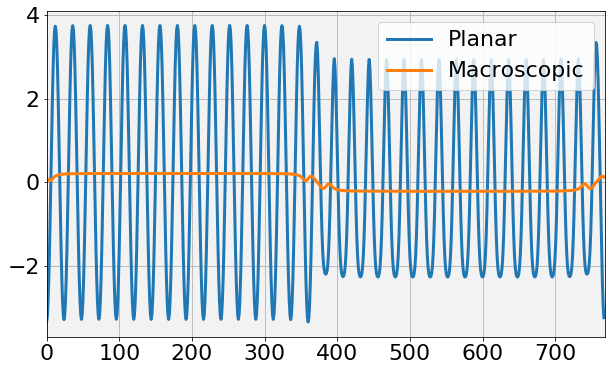

In [14]:
input_file = 'ZnS_ZnSe/LOCPOT_slab'
lattice_vector = 3.89
output_file = 'planar.dat'

vasp_pot, NGX, NGY, NGZ, Lattice = md.read_vasp_density(input_file)
vector_a,vector_b,vector_c,av,bv,cv = md.matrix_2_abc(Lattice)
resolution_x = vector_a/NGX
resolution_y = vector_b/NGY
resolution_z = vector_c/NGZ
grid_pot, electrons = md.density_2_grid(vasp_pot,NGX,NGY,NGZ)

## POTENTIAL
planar = md.planar_average(grid_pot,NGX,NGY,NGZ)
## MACROSCOPIC AVERAGE
macro  = md.macroscopic_average(planar,lattice_vector,resolution_z)

fig, ax1 = plt.subplots(1, 1, sharex=True)

textsize = 22
mpl.rcParams['xtick.labelsize'] = textsize
mpl.rcParams['ytick.labelsize'] = textsize
mpl.rcParams['figure.figsize'] = (10, 6)

ax1.plot(planar,label="Planar",lw=3)
ax1.plot(macro,label="Macroscopic",lw=3)

ax1.set_xlim(0,len(planar))

ax1.set_facecolor((0.95,0.95,0.95))
ax1.grid(True)

ax1.legend(fontsize=22)
plt.show()
np.savetxt(output_file,macro)

In [15]:
%%bash
nkpts=`grep NKPTS ZnS_ZnSe/OUTCAR_ZnS_av | awk '{print $4}'`
uband=`grep NELECT ZnS_ZnSe/OUTCAR_ZnS_av | awk '{print $3/2}'`
grep "  $uband   " ZnS_ZnSe/OUTCAR_ZnS_av | tail -$nkpts | awk '{print $2}' | sort -n | head | tail -1

0.4669


In [16]:
%%bash
nkpts=`grep NKPTS ZnS_ZnSe/OUTCAR_ZnSe_av | awk '{print $4}'`
uband=`grep NELECT ZnS_ZnSe/OUTCAR_ZnSe_av | awk '{print $3/2}'`
grep "  $uband   " ZnS_ZnSe/OUTCAR_ZnSe_av | tail -$nkpts | awk '{print $2}' | sort -n | head | tail -1

0.9267


In [17]:
dlnVa = (76.88 - 83.22) / 83.22 # ZnS
dlnVb = (89.90 - 83.22) / 83.22 # ZnSe

In [18]:
VBO_natural = 0.4669 - 0.9267 + (0.21 - - 0.21) + 0.83 * dlnVa - 1.23 * dlnVb

In [19]:
print 'Natural offset: %3.1f eV' % (VBO_natural)

Natural offset: -0.2 eV
